# ML Biasa (Jakarta)

## Cleaning

In [ ]:
import pandas as pd

data = pd.read_excel('/content/data_berita_content.xlsx')
dic = pd.read_csv('/content/normalize_word.csv')

import urllib.request

stop_words = []
stopword_data = urllib.request.urlopen('http://static.hikaruyuuki.com/wp-content/uploads/stopword_list_tala.txt').read().decode('utf-8').split('\n')
for line in stopword_data:
    stop_words.append(line)

In [ ]:
data = data.replace({'Label Text Classification': {2: 1}})

In [ ]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [ ]:
import re
import string

# bersihkan teks
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

In [ ]:
%%time
data['content'] = data['content'].apply(clean_text)
data['content'] = data['content'].apply(normalize)

CPU times: user 1min 7s, sys: 89 ms, total: 1min 7s
Wall time: 1min 8s


In [ ]:
def checkLen(data):
  return len(data.split())
data['Len'] = data['content'].apply(checkLen)

In [ ]:
len(data)

625

In [ ]:
data = data[data['Len'] > 10].reset_index(drop=True)

In [ ]:
len(data)

619

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 495
TEST size: 124


## Buat bag of word

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# data = dataCheck.copy()
# # Ubah fitur menjadi bentuk TFIDF dengan jumlah kata 150
mx_feat = 500
vectorizer = CountVectorizer(max_features=mx_feat)
bow_data_train = vectorizer.fit_transform(df_train['content'])
bow_data_train = pd.DataFrame.sparse.from_spmatrix(bow_data_train,columns=vectorizer.get_feature_names())

bow_data_test = vectorizer.transform(df_test['content'])
bow_data_test = pd.DataFrame.sparse.from_spmatrix(bow_data_test,columns=vectorizer.get_feature_names())
# data = data.join(bow_data)

In [ ]:
import joblib

joblib.dump(vectorizer, 'CountVectorizer.pkl')

['CountVectorizer.pkl']

In [ ]:
bow_data_train.values.shape

(495, 500)

In [ ]:
bow_data_test.values.shape

(124, 500)

## NN

In [ ]:
x_train = bow_data_train.values
x_test = bow_data_test.values

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train['Label Text Classification'].tolist())

y_train = encoder.transform(df_train['Label Text Classification'].tolist())
y_test = encoder.transform(df_test['Label Text Classification'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (495, 1)
y_test (124, 1)


In [ ]:
from keras.layers import Input, Dropout, Dense
from keras.models import Model

dropout = 0.2
def make_nn(dropout):
  inputs = Input(shape=(mx_feat,))
  layer = Dropout(dropout)(inputs)
  layer = Dense(16, activation="relu")(layer)
  layer = Dense(16, activation="relu")(layer)
  layer = Dense(1, activation="sigmoid")(layer)
  model = Model(inputs, layer)
  return model
model = make_nn(dropout)

In [ ]:
import tensorflow as tf

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10), verbose=1)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=70, callbacks=[lr_schedule],verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
62/62 [==============================] - 1s 6ms/step - loss: 0.7392 - accuracy: 0.5377 - val_loss: 0.7072 - val_accuracy: 0.5000
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2589254117941672e-06.
62/62 [==============================] - 0s 2ms/step - loss: 0.7315 - accuracy: 0.5330 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5848931924611134e-06.
62/62 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.5588 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 1.9952623149688796e-06.
62/62 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5793 - val_loss: 0.7062 - val_accuracy: 0.5000
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 2.51188643150958e-06.
62/62 [===========

(0.00030000000000000003, 0.003, 0.0, 2.0)

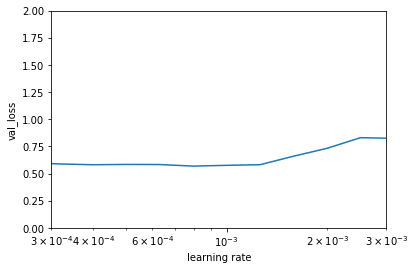

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('learning rate')
plt.ylabel('val_loss')
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([3*1e-4, 3*1e-3, 0, 2])

In [ ]:
model = make_nn(dropout)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.002869), metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=20,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
62/62 [==============================] - 1s 6ms/step - loss: 0.7322 - accuracy: 0.5249 - val_loss: 0.6129 - val_accuracy: 0.7097
Epoch 2/20
62/62 [==============================] - 0s 2ms/step - loss: 0.4543 - accuracy: 0.7777 - val_loss: 0.5447 - val_accuracy: 0.7500
Epoch 3/20
62/62 [==============================] - 0s 2ms/step - loss: 0.3413 - accuracy: 0.8547 - val_loss: 0.6218 - val_accuracy: 0.7500
Epoch 4/20
62/62 [==============================] - 0s 2ms/step - loss: 0.2383 - accuracy: 0.9075 - val_loss: 0.7047 - val_accuracy: 0.7339
Epoch 5/20
62/62 [==============================] - 0s 2ms/step - loss: 0.1693 - accuracy: 0.9441 - val_loss: 0.7343 - val_accuracy: 0.7500
Epoch 6/20
62/62 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9291 - val_loss: 0.7751 - val_accuracy: 0.7581
Epoch 7/20
62/62 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9362 - val_loss: 0.7592 - val_accuracy: 0.7339
Epoch 8/20
62/62 [==

In [ ]:
X_pred = model.predict(x_test).round()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(X_pred,y_test)

0.782258064516129

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [ ]:
!zip -r /content/jakarta_class.zip /content/model/


  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 88%)
  adding: content/model/keras_metadata.pb (deflated 87%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 63%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 10%)


In [ ]:
from google.colab import files
files.download("/content/jakarta_class.zip")
files.download("/content/CountVectorizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ML W2V (Jakarta)

## Cleaning

In [ ]:
import pandas as pd

data = pd.read_excel('/content/data_berita_content.xlsx')
dic = pd.read_csv('/content/normalize_word.csv')

import urllib.request

stop_words = []
stopword_data = urllib.request.urlopen('http://static.hikaruyuuki.com/wp-content/uploads/stopword_list_tala.txt').read().decode('utf-8').split('\n')
for line in stopword_data:
    stop_words.append(line)

In [ ]:
data = data.replace({'Label Text Classification': {2: 1}})

In [ ]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [ ]:
import re
import string

# bersihkan teks
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

In [ ]:
%%time
data['content'] = data['content'].apply(clean_text)
data['content'] = data['content'].apply(normalize)

CPU times: user 1min 8s, sys: 57 ms, total: 1min 8s
Wall time: 1min 8s


In [ ]:
def checkLen(data):
  return len(data.split())
data['Len'] = data['content'].apply(checkLen)

In [ ]:
len(data)

625

In [ ]:
data = data[data['Len'] > 10].reset_index(drop=True)

In [ ]:
len(data)

619

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 495
TEST size: 124


## Word2vec

In [ ]:
%%time
documents = [_content.split() for _content in df_train.content] 

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 12 ms


In [ ]:
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2285


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 10.4 s, sys: 97.6 ms, total: 10.5 s
Wall time: 5.7 s


(2434918, 3501856)

In [ ]:
w2v_model.most_similar("jakarta")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('merdeka', 0.642341136932373),
 ('medan', 0.5640632510185242),
 ('pemprov', 0.5234548449516296),
 ('balai', 0.4976435899734497),
 ('selasa', 0.48176389932632446),
 ('rabu', 0.46575337648391724),
 ('–', 0.45659810304641724),
 ('timur', 0.44270867109298706),
 ('wartawan', 0.43224775791168213),
 ('kalimantan', 0.42896780371665955)]

## LSTM

In [ ]:
%%time

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.content)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 14976
CPU times: user 159 ms, sys: 92.5 ms, total: 251 ms
Wall time: 147 ms


In [ ]:
%%time

from keras.preprocessing.sequence import pad_sequences

# KERAS
SEQUENCE_LENGTH = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.content), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.content), maxlen=SEQUENCE_LENGTH)

CPU times: user 77.7 ms, sys: 0 ns, total: 77.7 ms
Wall time: 78.1 ms


In [ ]:
labels = []
labels = df_train['Label Text Classification'].unique().tolist()
labels

[0, 1]

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train['Label Text Classification'].tolist())

y_train = encoder.transform(df_train['Label Text Classification'].tolist())
y_test = encoder.transform(df_test['Label Text Classification'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (495, 1)
y_test (124, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (495, 300)
y_train (495, 1)

x_test (124, 300)
y_test (124, 1)


In [ ]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(14976, 300)


In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

def make_model():
  model = Sequential()
  model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
  model.add(Dropout(0.5))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))
  return model

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          4492800   
_________________________________________________________________
dropout_73 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_215 (Dense)            (None, 1)                 101       
Total params: 4,653,301
Trainable params: 160,501
Non-trainable params: 4,492,800
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
%%time
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 8

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10), verbose=1)

model = make_model()

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=[lr_schedule],
                    verbose=1)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
56/56 [==============================] - 35s 565ms/step - loss: 0.7083 - acc: 0.4889 - val_loss: 0.7135 - val_acc: 0.4800
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2589254117941672e-06.
56/56 [==============================] - 31s 547ms/step - loss: 0.7061 - acc: 0.4793 - val_loss: 0.7129 - val_acc: 0.4800
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5848931924611134e-06.
56/56 [==============================] - 31s 546ms/step - loss: 0.7060 - acc: 0.4631 - val_loss: 0.7120 - val_acc: 0.4600
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 1.9952623149688796e-06.
56/56 [==============================] - 31s 548ms/step - loss: 0.7035 - acc: 0.4822 - val_loss: 0.7110 - val_acc: 0.4800
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 2.51188643150958e-06.
56/56 [==============================] - 

(1e-06, 1.0, 0.0, 2.0)

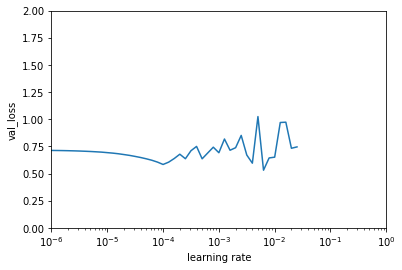

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('learning rate')
plt.ylabel('val_loss')
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e0, 0, 2])

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

model = make_model()

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0031), metrics=['accuracy'])

history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=20,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
62/62 [==============================] - 39s 578ms/step - loss: 0.6766 - accuracy: 0.5651 - val_loss: 0.6185 - val_accuracy: 0.6855
Epoch 2/20
62/62 [==============================] - 35s 566ms/step - loss: 0.5495 - accuracy: 0.7148 - val_loss: 0.6425 - val_accuracy: 0.6532
Epoch 3/20
62/62 [==============================] - 35s 568ms/step - loss: 0.4736 - accuracy: 0.7792 - val_loss: 0.6993 - val_accuracy: 0.6290
Epoch 4/20
62/62 [==============================] - 35s 566ms/step - loss: 0.3991 - accuracy: 0.8284 - val_loss: 0.6528 - val_accuracy: 0.6532
Epoch 5/20
62/62 [==============================] - 35s 565ms/step - loss: 0.3656 - accuracy: 0.8381 - val_loss: 0.7313 - val_accuracy: 0.6452
Epoch 6/20
62/62 [==============================] - 35s 569ms/step - loss: 0.3114 - accuracy: 0.8707 - val_loss: 0.7710 - val_accuracy: 0.6210
Epoch 7/20
62/62 [==============================] - 35s 568ms/step - loss: 0.2180 - accuracy: 0.9198 - val_loss: 0.8137 - val_accuracy: 0.6532

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

16/16 [==============================] - 1s 66ms/step - loss: 1.4141 - accuracy: 0.6774

ACCURACY: 0.6774193644523621
LOSS: 1.4141312837600708
CPU times: user 1.9 s, sys: 20.5 ms, total: 1.92 s
Wall time: 1.1 s
